# **casting product image data for quality inspection**
industrial data,casting manufacturing product, quality inspection, automation



Casting is a manufacturing process in which a liquid material is usually poured into a mould, which contains a hollow cavity of the desired shape, and then allowed to solidify.

Reason for collect this data is casting defects!!
Casting defect is an undesired irregularity in a metal casting process.

There are many types of defect in casting like blow holes, pinholes, burr, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc.

Defects are an unwanted thing in casting industry. For removing this defective product all industry have their quality inspection department. But the main problem is this inspection process is carried out manually. It is a very time-consuming process and due to human accuracy, this is not 100% accurate.

contain
These all photos are top view of submersible pump impeller(google search for better understanding).

The dataset contains total 7348 image data. These all are the size of (300*300) pixels grey-scaled images. In all images, augmentation already applied.

Also uploaded images size of 512x512 grayscale. This data set is without Augmentation. This contains 519 ok_front and 781 def_front impeller images.

For capturing these images requires stable lighting, for this we made a special arrangement.

there are mainly two categories:

1) Defective

2)Ok



Both train and test folder contains def_front and ok_front subfolders.

train: def_front have 3758 and ok_front have 2875 images

test: def_front have:- def_front have 453 and ok_front have 262 images

3758==> C:\Users\HP\Downloads\casting quality inspection\casting_data\casting_data\train\def_front

2875== > C:\Users\HP\Downloads\casting quality inspection\casting_data\casting_data\train\ok_front

453 def front ===> C:\Users\HP\Downloads\casting quality inspection\casting_data\casting_data\test\def_front





Our casting product data comprises top-view JPEG images of cast submersible pump impellers, provided by Pilot Technocast. Images were captured with Canon EOS 1300D DSLR camera. Every images are 300×300 pixels in size and already labeled as either def_front (defective castings) or ok_front (non-defective).

The folder train in the input directory contains images that are used for model training/validation. Images located in the test folder are used to test the trained model's performance

In [16]:
#helper methods:
def get_model(model_name, pretrained=False):
    return models.__dict__[model_name](pretrained)

def imshow(img, mean, std, text=None, should_save=False):
    # convert from torch tensor to numpy array
    img_np = img.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

    # denormalize
    img_np = img_np * std + mean
    img_np = img_np.clip(0., 1.)

    # plot
    plt.axis("off")
    if text:
        plt.text(160, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()


def show_image_pair(img1, img2, text=None):
    concat = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), 0)
    imshow(torchvision.utils.make_grid(concat), text)

In [4]:
# Import relevant libraries for the project
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
plt.style.use('ggplot')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile
import os

# Define the path to your dataset zip file in Google Drive
google_drive_path = '/content/drive/My Drive/computervision/casting quality inspection.zip'

# Specify the directory where you want to extract the dataset
extract_dir = '/content/dataset/'

# Verify the existence of the zip file
if os.path.exists(google_drive_path):
    # Extract the zip file
    with zipfile.ZipFile(google_drive_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print(f"File not found: {google_drive_path}")

In [7]:
# Define the path to the casting_data directory
casting_data_dir = os.path.join(extract_dir, 'casting_data', 'casting_data')


# Update DATA_DIR to the path in your Google Colab environment
DATA_DIR = casting_data_dir


In [8]:
# Check directory contents
os.listdir(DATA_DIR)


['train', 'test']

In [9]:
# Define paths for the training and testing data
trn_dir = os.path.join(DATA_DIR, 'train')
test_dir = os.path.join(DATA_DIR, 'test')


In [10]:
# Check the contents of the training directory
os.listdir(trn_dir)


['ok_front', 'def_front']

In [11]:

# Check the contents of the testing directory
os.listdir(test_dir)

['ok_front', 'def_front']

In [12]:
!pip install pillow

In [2]:

# Commented out IPython magic to ensure Python compatibility.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms





In [13]:
# Specify the directory of the "def_front" folder
def_front_dir = os.path.join(trn_dir, 'def_front')

# List all files in the "def_front" folder
def_front_files = os.listdir(def_front_dir)

# Print the first 5 file names
print(def_front_files[:5])


['cast_def_0_1042.jpeg', 'cast_def_0_7976.jpeg', 'cast_def_0_5290.jpeg', 'cast_def_0_8910.jpeg', 'cast_def_0_9937.jpeg']


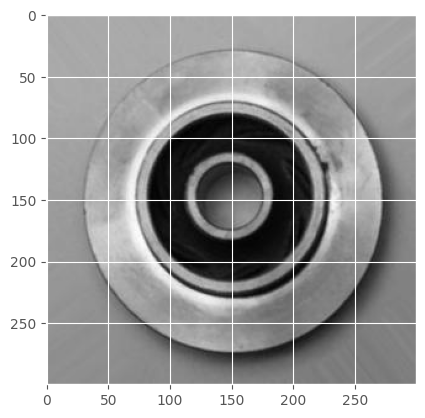

In [14]:
import matplotlib.pyplot as plt

# Load and display the 4th image from the "def_front" folder
img = plt.imread(os.path.join(def_front_dir, def_front_files[3]))
plt.imshow(img)
plt.show()



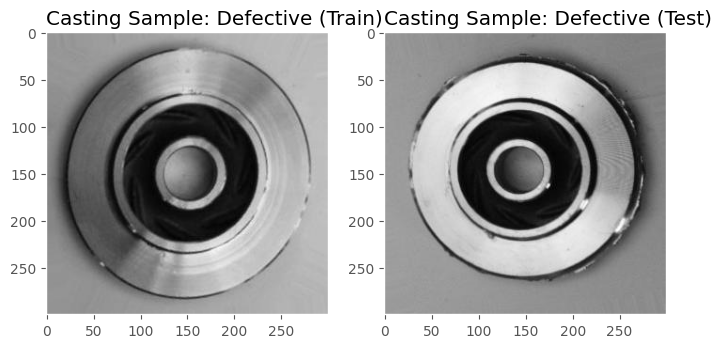

In [21]:
# Specify directory of train data
trn_dir = os.path.join(DATA_DIR, 'train', 'def_front')  # Class label: Defective

# Specify directory of test data
test_dir = os.path.join(DATA_DIR, 'test', 'def_front')

# Get the list of file and directory names
trn_dir_contents = os.listdir(trn_dir)
test_dir_contents = os.listdir(test_dir)

# Plot samples of defective casting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sample_def_train = plt.imread(os.path.join(trn_dir, trn_dir_contents[0]))
sample_def_test = plt.imread(os.path.join(test_dir, test_dir_contents[0]))
axes[0].imshow(sample_def_train)
axes[1].imshow(sample_def_test)
axes[0].set_title('Casting Sample: Defective (Train)', loc='left')
axes[1].set_title('Casting Sample: Defective (Test)', loc='left')
axes[0].grid(False)
axes[1].grid(False)
plt.show()


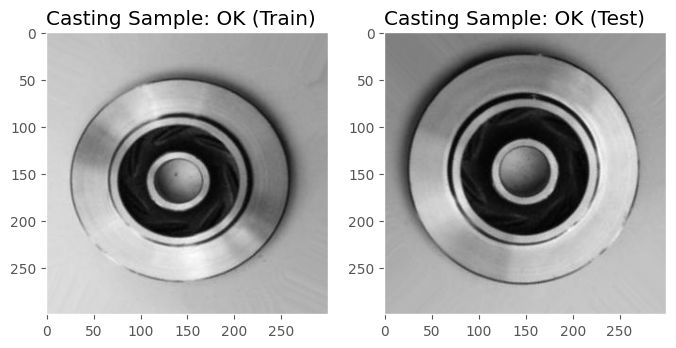

In [22]:
# Specify directory of train data
trn_dir_ok = os.path.join(DATA_DIR, 'train', 'ok_front')  # Class label: OK

# Specify directory of test data
test_dir_ok = os.path.join(DATA_DIR, 'test', 'ok_front')

# Get the list of file and directory names
trn_dir_ok_contents = os.listdir(trn_dir_ok)
test_dir_ok_contents = os.listdir(test_dir_ok)

# Plot samples of non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sample_ok_train = plt.imread(os.path.join(trn_dir_ok, trn_dir_ok_contents[0]))
sample_ok_test = plt.imread(os.path.join(test_dir_ok, test_dir_ok_contents[0]))
axes[0].imshow(sample_ok_train)
axes[1].imshow(sample_ok_test)
axes[0].set_title('Casting Sample: OK (Train)', loc='left')
axes[1].set_title('Casting Sample: OK (Test)', loc='left')
axes[0].grid(False)
axes[1].grid(False)
plt.show()


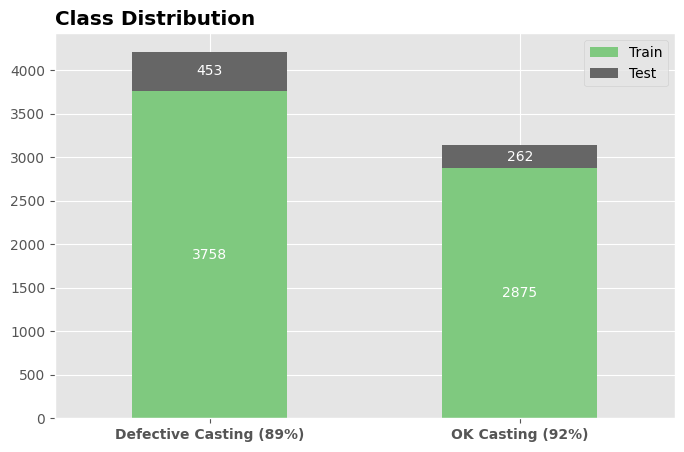

In [30]:
# Specify directory of train data for defective casting
trn_dir_def = os.path.join(DATA_DIR, 'train', 'def_front')  # Class label: Defective

# Specify directory of test data for defective casting
test_dir_def = os.path.join(DATA_DIR, 'test', 'def_front')

# Create dataframe of class distribution for defective castings
dist_df_def = pd.DataFrame({'Defective': [len(os.listdir(trn_dir_def)), len(os.listdir(test_dir_def))]}, index=['Train', 'Test'])

# Specify directory of train data for non-defective casting
trn_dir_ok = os.path.join(DATA_DIR, 'train', 'ok_front')  # Class label: OK

# Specify directory of test data for non-defective casting
test_dir_ok = os.path.join(DATA_DIR, 'test', 'ok_front')

# Create dataframe of class distribution for non-defective castings
dist_df_ok = pd.DataFrame({'OK': [len(os.listdir(trn_dir_ok)), len(os.listdir(test_dir_ok))]}, index=['Train', 'Test'])

# Merge the two dataframes
merged_dist_df = pd.concat([dist_df_def, dist_df_ok], axis=1)

# Visualize class distribution
ax = merged_dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8, 5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() - 0.25,
            bar.get_y() + bar.get_height() / 2,
            int(bar.get_height()),
            ha='center', va='center', color='white')

pct_def = 100 * dist_df_def['Defective']['Train'] / dist_df_def['Defective'].sum()
pct_ok = 100 * dist_df_ok['OK']['Train'] / dist_df_ok['OK'].sum()
ax.set_xticklabels([f'Defective Casting ({pct_def:.0f}%)', f'OK Casting ({pct_ok:.0f}%)'], weight='bold')
plt.show()


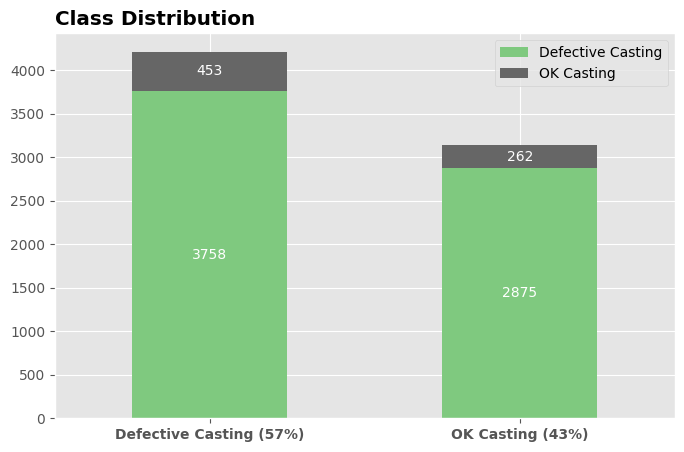

In [56]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(seed)


# Define the path to the casting_data directory
casting_data_dir = os.path.join(extract_dir, 'casting_data', 'casting_data')

# Define paths to your dataset
# Update DATA_DIR to the path in your Google Colab environment
DATA_DIR = casting_data_dir

train_dir_def = os.path.join(DATA_DIR, 'train', 'def_front')
test_dir_def = os.path.join(DATA_DIR, 'test', 'def_front')
train_dir_ok = os.path.join(DATA_DIR, 'train', 'ok_front')
test_dir_ok = os.path.join(DATA_DIR, 'test', 'ok_front')

# Calculate class distribution
defective_train_count = len(os.listdir(train_dir_def))
defective_test_count = len(os.listdir(test_dir_def))
ok_train_count = len(os.listdir(train_dir_ok))
ok_test_count = len(os.listdir(test_dir_ok))

# Visualize class distribution
class_distribution = {
    'Train': {'Defective Casting': defective_train_count, 'OK Casting': defective_test_count},
    'Test': {'Defective Casting': ok_train_count, 'OK Casting': ok_test_count}
}

dist_df_def = pd.DataFrame(class_distribution)

# Plot the class distribution
ax = dist_df_def.T.plot(kind='bar', stacked=True, rot=0, figsize=(8, 5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() - 0.25,
            bar.get_y() + bar.get_height() / 2,
            int(bar.get_height()),
            ha='center', va='center', color='white')

pct_def = 100 * defective_train_count / (defective_train_count + ok_train_count)
pct_ok = 100 * ok_train_count / (defective_train_count + ok_train_count)
ax.set_xticklabels([f'Defective Casting ({pct_def:.0f}%)', f'OK Casting ({pct_ok:.0f}%)'], weight='bold')
plt.show()




In [51]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [52]:
# Data augmentation for the test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [55]:


# Create data generators for training and validation
train_set = train_datagen.flow_from_directory(
    train_dir_ok,  # Use train_dir_def or train_dir_ok based on your needs
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=seed
)

valid_set = train_datagen.flow_from_directory(
    train_dir_ok,  # Use train_dir_def or train_dir_ok based on your needs
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=seed
)

test_set = test_datagen.flow_from_directory(
    test_dir_ok,  # Use test_dir_def or test_dir_ok based on your needs
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=seed
)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [ ]:
# Create a CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), input_shape=(*img_size, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = cnn_model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=20,
    validation_data=valid_set,
    validation_steps=len(valid_set)
)


In [ ]:
# Evaluate the model on the test set
loss, accuracy = cnn_model.evaluate(test_set, steps=len(test_set))
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

In [ ]:
# Generate predictions
y_pred = cnn_model.predict(test_set)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions


In [ ]:
# Evaluate the model
print(classification_report(test_set.classes, y_pred, target_names=['OK', 'Defective']))
conf_matrix = confusion_matrix(test_set.classes, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
# Define instances of ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (300, 300), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'rgb',  # Change 'grayscale' to 'rgb' if your images are in color
             'classes': {'ok_front': 0, 'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}


# Generate data by iterating through directories
train_set = train_gen.flow_from_directory(
    directory=trn_dir, subset='training', **arg_train)
valid_set = train_gen.flow_from_directory(
    directory=trn_dir, subset='validation', **arg_train)
test_set = test_gen.flow_from_directory(
    directory=test_dir, **arg_test)


Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [33]:
# Define CNN model architecture
cnn_model = Sequential([
    # First block
    Conv2D(32, 3, activation='relu', padding='same', strides=2,
           input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    # Second block
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    # Flatenning
    Flatten(),
    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')        # Only 1 output
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Default lr
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 23104)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
# Load saved model
best_model = load_model('./CNN_Casting_Inspection.hdf5')

# Make predictions on images in the test set
y_pred_prob = best_model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

In [ ]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, digits=4))

In [ ]:
class_map = {0: 'OK', 1: 'Defective'}
images, labels = next(iter(test_set))
images = images.reshape(batch_size,*img_size)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
fig.suptitle('Prediction on Test Images', y=0.98, weight='bold', size=14)
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[label]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()